In [16]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [17]:
# load the wine data set
# characteristics: 11 features, 4898 samples, 11 classes (0-10)

# load the data set
wine = np.loadtxt('datasets/winequality/winequality-white.csv', delimiter=';', skiprows=1)

# extract the data and labels
wine_data = []
wine_labels = []

for row in wine:
    wine_data.append(row[:-1])
    wine_labels.append(row[-1])

# convert to numpy arrays
wine_data = np.array(wine_data)
wine_labels = np.array(wine_labels)

wine_possible_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [18]:
# load the HAR data set
# characteristics: 561 features, 10299 samples, 6 classes (1-6)

# load the files
X_test = np.loadtxt('datasets/UCI HAR Dataset/test/X_test.txt')
y_test = np.loadtxt('datasets/UCI HAR Dataset/test/y_test.txt')
X_train = np.loadtxt('datasets/UCI HAR Dataset/train/X_train.txt')
y_train = np.loadtxt('datasets/UCI HAR Dataset/train/y_train.txt')

# format the data set so that all of this data is in one data set due to the given charactersitics
har_data = np.concatenate((X_test, X_train), axis=0)
har_labels = np.concatenate((y_test, y_train), axis=0)

har_possible_labels = np.array([1, 2, 3, 4, 5, 6])


In [19]:
# implement minimum-probability-of-error classifier, assuming the class conditional pdfs are Gaussian
# using all available samples from a class, with sample averages, estimate mean vectors and covariance matrices
# using sample counts, also estimate class priors

# calculate mean vectors, covariance matrices, and priors for each class
# also return the unique labels
def calculate_parameters(data: np.array, labels: np.array) -> tuple[np.array, np.array, np.array, np.array]:
    """
    Calculates the mean vectors, covariance matrices, and priors for each class.

    Args:
        data (np.array): The data set.
        labels (np.array): The labels for the data set.

    Returns:
        tuple[np.array, np.array, np.array, np.array]: The unique labels, mean vectors, covariance matrices, and priors.
    """
    # get the unique labels
    unique_labels = np.unique(labels)

    # calculate the mean vectors
    mean_vectors = []
    for label in unique_labels:
        mean_vectors.append(np.mean(data[labels == label], axis=0))

    # calculate the covariance matrices
    covariance_matrices = []
    for label in unique_labels:
        covariance_matrices.append(np.cov(data[labels == label].T))

    # calculate the priors
    priors = []
    for label in unique_labels:
        priors.append(np.sum(labels == label) / len(labels))

    # convert to numpy arrays
    mean_vectors = np.array(mean_vectors)
    covariance_matrices = np.array(covariance_matrices)
    priors = np.array(priors)

    return unique_labels, mean_vectors, covariance_matrices, priors

In [20]:
# mean vector and covariance matrix for wine data set
wine_unique_labels, wine_mean_vectors, wine_covariance_matrices, wine_priors = calculate_parameters(wine_data, wine_labels)

# mean vector and covariance matrix for HAR data set
har_unique_labels, har_mean_vectors, har_covariance_matrices, har_priors = calculate_parameters(har_data, har_labels)

In [21]:
# add a regularization term to the covariance matrices to ensure the regularized covaraince matrix has all eigenvalues larger than 0
# this is done by adding a small value to the diagonal of the covariance matrix
# for now, we'll use a value on the order of arithmetic average of sample covariance matrices
def regularize_covariance_matrices(covariance_matrices: np.array) -> np.array:
    """
    Regularizes the covariance matrices.

    Args:
        covariance_matrices (np.array): The covariance matrices.

    Returns:
        np.array: The regularized covariance matrices.
    """
    # calculate the average covariance matrix
    average_covariance_matrix = np.mean(covariance_matrices, axis=0)

    # calculate the regularization term
    regularization_term = np.mean(np.diag(average_covariance_matrix))

    print("The regularization term is: ", regularization_term)

    # add the regularization term to the covariance matrices
    for i in range(len(covariance_matrices)):
        covariance_matrices[i] += regularization_term * np.eye(covariance_matrices[i].shape[0])

    return covariance_matrices

In [22]:
# add the regularization term to the covariance matrices
wine_covariance_matrices = regularize_covariance_matrices(wine_covariance_matrices)
har_covariance_matrices = regularize_covariance_matrices(har_covariance_matrices)

The regularization term is:  353.1966224105839
The regularization term is:  0.03549356441569865


In [23]:
def minimum_probability_of_error_classifier(data: np.array, unique_labels: np.array, mean_vectors: np.array, covariance_matrices: np.array, priors: np.array) -> np.array:
    """
    Implements the minimum-probability-of-error classifier.

    Args:
        data (np.array): The data set to classify.
        unique_labels (np.array): The unique, used labels for the data set.
        mean_vectors (np.array): The mean vectors for each class.
        covariance_matrices (np.array): The covariance matrices for each class.
        priors (np.array): The priors for each class.

    Returns:
        np.array: The predicted labels for the data set.
    """
    # calculate the probabilities for all data points and classes
    probabilities = np.zeros((data.shape[0], len(unique_labels)))

    for i, label in enumerate(unique_labels):
        probabilities[:, i] = multivariate_normal.pdf(data, mean_vectors[i], covariance_matrices[i]) * priors[i]

    # find the index of the maximum probability for each data point
    max_probability_indices = np.argmax(probabilities, axis=1)

    # use the max_probability_indices to find the predicted labels
    predicted_labels = unique_labels[max_probability_indices]

    return predicted_labels

In [24]:
# implement a function that will count the errors, the error probability estimate, and the confusion matrix
def calculate_classification_metrics(predicted_labels: np.array, actual_labels: np.array, possible_labels: np.array) -> tuple[int, float, np.array]:
    """
    Calculates the number of errors, the error probability estimate, and the confusion matrix.

    Args:
        predicted_labels (np.array): The predicted labels.
        actual_labels (np.array): The actual labels.
        possible_labels (np.array): All the possible labels for the data set.

    Returns:
        tuple[int, float, np.array]: The number of errors, the error probability estimate, and the confusion matrix.
    """
    # initialize the number of errors
    number_of_errors = 0

    # initialize the confusion matrix
    confusion_matrix = np.zeros((len(possible_labels), len(possible_labels)), dtype=int)

    # iterate through the predicted labels
    for i in range(len(predicted_labels)):
        # check if the predicted label is correct
        if predicted_labels[i] != actual_labels[i]:
            # increment the number of errors
            number_of_errors += 1

        # increment the confusion matrix
        actual_index = np.where(possible_labels == actual_labels[i])[0][0]
        predicted_index = np.where(possible_labels == predicted_labels[i])[0][0]
        confusion_matrix[actual_index, predicted_index] += 1

    # calculate the error probability estimate
    error_probability_estimate = number_of_errors / len(predicted_labels)

    return number_of_errors, error_probability_estimate, confusion_matrix

In [25]:
# classify the wine data set
wine_predicted_labels = minimum_probability_of_error_classifier(wine_data, wine_unique_labels, wine_mean_vectors, wine_covariance_matrices, wine_priors)

In [26]:
# calculate the classification metrics for the wine data set
wine_number_of_errors, wine_error_probability_estimate, wine_confusion_matrix = calculate_classification_metrics(wine_predicted_labels, wine_labels, wine_possible_labels)

# print the classification metrics for the wine data set
print("The number of errors for the wine data set is: ", wine_number_of_errors)
print("The error probability estimate for the wine data set is: ", wine_error_probability_estimate)
print("The confusion matrix for the wine data set is:")
print(wine_confusion_matrix)

The number of errors for the wine data set is:  2683
The error probability estimate for the wine data set is:  0.5477746018783177
The confusion matrix for the wine data set is:
[[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    3    0    3   14    0    0    0    0]
 [   0    0    0    1    0    7  155    0    0    0    0]
 [   0    0    0    2    0  162 1293    0    0    0    0]
 [   0    0    0    0    0  148 2050    0    0    0    0]
 [   0    0    0    0    0   17  863    0    0    0    0]
 [   0    0    0    0    0    6  169    0    0    0    0]
 [   0    0    0    0    0    0    5    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]]


In [27]:
# classify the HAR data set
har_predicted_labels = minimum_probability_of_error_classifier(har_data, har_unique_labels, har_mean_vectors, har_covariance_matrices, har_priors)

In [28]:
# calculate the classification metrics for the HAR data set
har_number_of_errors, har_error_probability_estimate, har_confusion_matrix = calculate_classification_metrics(har_predicted_labels, har_labels, har_possible_labels)

# print the classification metrics for the HAR data set
print("The number of errors for the HAR data set is: ", har_number_of_errors)
print("The error probability estimate for the HAR data set is: ", har_error_probability_estimate)
print("The confusion matrix for the HAR data set is:")
print(har_confusion_matrix)

The number of errors for the HAR data set is:  263
The error probability estimate for the HAR data set is:  0.02553645985047092
The confusion matrix for the HAR data set is:
[[1717    4    1    0    0    0]
 [   1 1543    0    0    0    0]
 [   2   53 1351    0    0    0]
 [   0    1    0 1584  192    0]
 [   0    0    0    9 1897    0]
 [   0    0    0    0    0 1944]]


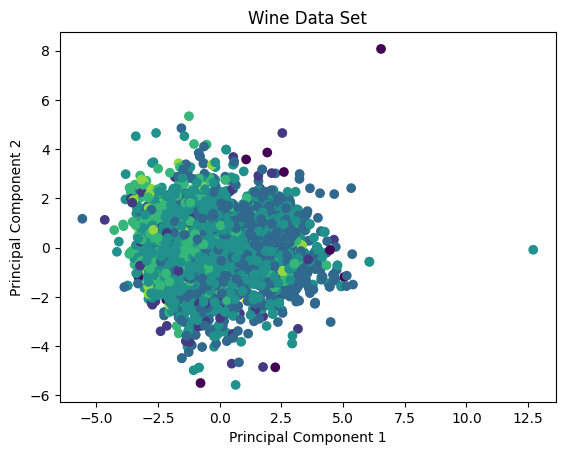

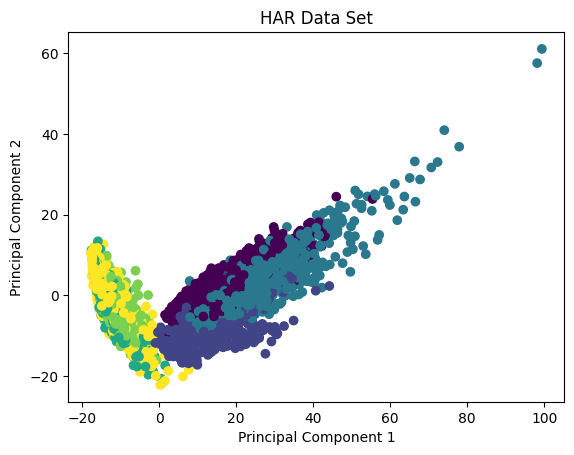

In [30]:
# use PCA to visualize the data sets
# scale the data sets
scaler = StandardScaler()
wine_scaled_data = scaler.fit_transform(wine_data)
har_scaled_data = scaler.fit_transform(har_data)

# create the PCA objects
wine_pca = PCA(n_components=2)
har_pca = PCA(n_components=2)

# fit the PCA objects
wine_pca.fit(wine_scaled_data)
har_pca.fit(har_scaled_data)

# transform the data sets
wine_pca_data = wine_pca.transform(wine_scaled_data)
har_pca_data = har_pca.transform(har_scaled_data)

# plot the data sets
# plot the wine data set
plt.figure()
plt.scatter(wine_pca_data[:, 0], wine_pca_data[:, 1], c=wine_labels)
plt.title("Wine Data Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# plot the HAR data set
plt.figure()
plt.scatter(har_pca_data[:, 0], har_pca_data[:, 1], c=har_labels)
plt.title("HAR Data Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


Part of this exercise was making the assumption that the class conditional pdf of features for each class was Gaussian. One way of analyzing if this decision was appropriate for the data sets was to look at the confusion matrices. When looking at the confusion matrix for the wine data set, it's clear that the classifier is not a good fit. The error probability estimate for the set is over 50% and the confusion matrix has a significant amount of misclassified samples, especially for label 6. On the other hand, when looking at the HAR datat set, the confusion matrix yields much more promising results. The diagonal contains the majority of the values in the matrix, and the error probability estimate is around 3%. 

The model choice has a direct impact on how the confusion matrix and probability of error. Since the wine data set was not a good fit with a Gaussian model, it led the classifier to have an incredibly high error probability and have a notable amount of misclassifications on the non-diagonal. For a data set that was much more Gaussian with the HAR set, the model performed much better.

When looking at the PCA visualization for the two data sets, the structure of the data under 2 principal components makes it a little more clear why the Gaussian assumption fit better for the HAR. For the wine data set, the data points are very clustered and have signficant overlap. For the HAR data set, there are clearer regions for each label. We look at the principal components to observe the most significant variations in the data. This is useful since it gives better insight into the separability of the data (or lackof in the wine data set instance).